## Basic experiment about transfer learning
Jeremy shares jupyter notebooks stepping through ULMFit, his groundbreaking work with Sebastian Ruder last year to successfully apply transfer learning to NLP. The technique involves training a language model on a large corpus, fine-tuning it for a different and smaller corpus, and then adding a classifier to the end. <br>

I use transfer learning for this task, to do that, we’ll use a pre-trained model based on Wikipedia called wikitext-103. It is a model that’s already trained from the Wikipedia dataset. It is a model that’s already trained from the Wikipedia dataset(or ‘corpus’ in NLP terms) to predict the next words from a giving unfinished sentence. <br>

I will leverage the ‘language knowledge’ the model already learned from the Wikipedia dataset and build on top of that. To achieve the best results, we’ll need to ‘fine-tune’ the model to make it learn a bit from our ‘comments’ dataset since what people say in the comments are not necessarily the same with the more formal Wiki. Once the language model is fine-tuned, we can then use it to further do our classification task.

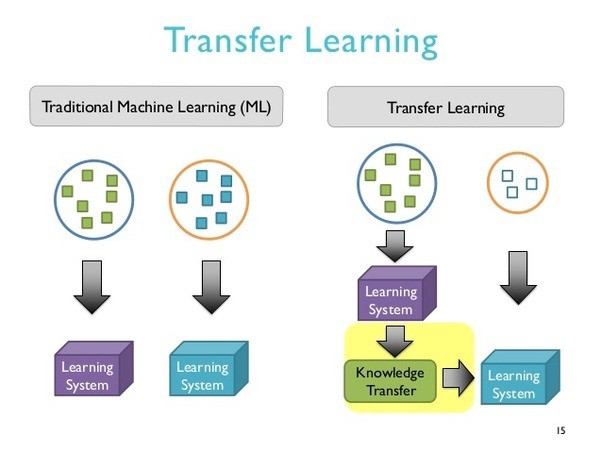

In [ ]:
from fastai.text import *

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [7]:
np.random.seed(101)

In [13]:
data = pd.read_table('train.tsv')
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [74]:
# make a path for dataset
path = Path('/Users/philo/my_repo/Data projects/sentiment analysis')
path.ls()

[WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/.ipynb_checkpoints'),
 WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/buildmodel.ipynb'),
 WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/sampleSubmission.csv'),
 WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/sentiment_analysis.ipynb'),
 WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/submit_1.csv'),
 WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/submit_2.csv'),
 WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/submit_3.csv'),
 WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/submit_4.csv'),
 WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/submit_5.csv'),
 WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/test transfer learning.ipynb'),
 WindowsPath('/Users/philo/my_repo/Data projects/sentiment analysis/test.tsv'),
 WindowsPath('/Users/philo/my_repo

In [80]:
# read in the data and have a peak
df_train = pd.read_csv(path/'train.tsv', sep = '\t')
df_test = pd.read_csv(path/'test.tsv', sep = '\t')
df = df_train.append(df_test)
print(df.shape)
df.head()

(222352, 4)


,Phrase,PhraseId,SentenceId,Sentiment
0,A series of escapades demonstrating the adage ...,1,1,1.0
1,A series of escapades demonstrating the adage ...,2,1,2.0
2,A series,3,1,2.0
3,A,4,1,2.0
4,series,5,1,2.0


In [81]:
#Behind the scenes, the previous functions will create a training, validation and 
#maybe test TextList that will be tokenized and numericalized

bs = 64
data_lm = (TextList.from_df(df, path, cols='Phrase')
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=bs))

* Firstly I tell the model to use comment_text as input (TextList.from_df(df, path, cols=’comment_text’)) Note here I can also include the test.csv into the language model. It’s not considered ‘cheating’ since we are not using the labels, just do language model training.

* Split the training dataset into train/validation set by random 10/90 percent. (.split_by_rand_pct(0.1))

* Ignore the given labels( since we are only fine-tuning the language model, not training the classifier yet) and use the language model’s ‘predict next word’ as labels. (.label_for_lm())

* Build the data into a databunch, with batch size bs. (.databunch(bs=bs))

In [82]:
data_lm.show_batch()

idx,text
0,"the xxbos adage xxbos that what is good for the goose xxbos that xxbos what is good for the goose xxbos what xxbos is good for the goose xxbos is xxbos good for the goose xxbos good xxbos for the goose xxbos for xxbos the goose xxbos goose xxbos is also good for the gander , some of which occasionally amuses but none of which amounts to much of a"
1,"uncluttered , resonant gem xxbos , resonant gem xxbos resonant gem xxbos gem xxbos that relays its universal points without lectures or confrontations xxbos relays its universal points xxbos relays xxbos its universal points xxbos universal points xxbos universal xxbos points xxbos without lectures or confrontations xxbos lectures or confrontations xxbos lectures or xxbos lectures xxbos confrontations xxbos xxmaj the story alone could force you to scratch a hole in"
2,"of less xxbos xxmaj the otherwise good - naturedness of xxmaj mr. xxmaj deeds , with its embrace xxbos xxmaj the otherwise good - naturedness of xxmaj mr. xxmaj deeds , xxbos xxmaj the otherwise good - naturedness of xxmaj mr. xxmaj deeds xxbos xxmaj the otherwise good - naturedness xxbos otherwise good - naturedness xxbos good - naturedness xxbos of xxmaj mr. xxmaj deeds xxbos xxmaj mr. xxmaj deeds"
3,on true events xxbos true events xxbos events xxbos somehow makes it all the more compelling . xxbos makes it all the more compelling . xxbos makes it all the more compelling xxbos it all the more compelling xxbos all the more compelling xxbos more compelling xxbos xxmaj the xxmaj santa xxmaj clause 2 proves itself a more streamlined and thought out encounter than the original could ever have hoped
4,of silent film . xxbos 's a glorious spectacle like those xxup d.w. xxmaj griffith made in the early days of silent film xxbos a glorious spectacle like those xxup d.w. xxmaj griffith made in the early days of silent film xxbos a glorious spectacle xxbos glorious spectacle xxbos like those xxup d.w. xxmaj griffith made in the early days of silent film xxbos those xxup d.w. xxmaj griffith made


In [83]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [84]:
data_lm.train_ds[3]

(Text xxbos of escapades demonstrating the adage that what is good for the goose,
 EmptyLabel )

#### Time for some typical fast.ai learning rate adjustments and training

In [85]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


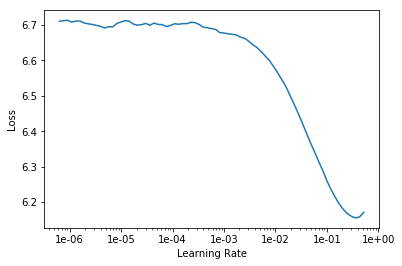

In [86]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

We put our databunch into a language_model_learner, tell it the language model base we want to use (AWD_LSTM) and assign a default dropout rate of 0.3. From the LR Finder graph, find the biggest downward slope and pick the middle point as our learning rate.

In [87]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.931625,3.752922,0.361126,31:31


In [101]:
learn.save('first_head')

In [102]:
learn.load('first_head');

In [103]:
learn.unfreeze()

### Test fine tune model
Test to fill the sentence

In [104]:
learn.fit_one_cycle(6, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.328736,3.231193,0.435615,51:08
1,2.739552,2.576641,0.551151,51:07
2,2.313551,2.224806,0.612946,51:02
3,2.082409,2.076187,0.639425,50:41
4,1.942189,2.010203,0.648695,53:20
5,1.863629,2.000243,0.650536,51:15


In [105]:
learn.save('fine Tune')

In [106]:
learn.load('fine Tune')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (200117 items)
x: LMTextList
xxbos a series of escapades demonstrating the adage that what is good for the goose,xxbos a series,xxbos series,xxbos of escapades demonstrating the adage that what is good for the goose,xxbos of
y: LMLabelList
,,,,
Path: \Users\philo\my_repo\Data projects\sentiment analysis;

Valid: LabelList (22235 items)
x: LMTextList
xxbos intimate heart,xxbos xxmaj esther seems to remain an unchanged dullard,xxbos becomes predictably conventional,xxbos carrying every gag two or three times,xxbos a fourteen - year old xxmaj ferris xxmaj bueller
y: LMLabelList
,,,,
Path: \Users\philo\my_repo\Data projects\sentiment analysis;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(17752, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(17752, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)

In [131]:
# save the encoder for next step use
learn.save_encoder('fine_tuned_enc')

In [130]:
test = "I loved Tom"
n_w = 8
n_sentence = 1
print("\n".join(learn.predict(test, n_w, temperature=0.75) for _ in range(n_sentence)))

I loved Tom Hanks in the first place xxbos


## Create a classifier

In [132]:
test = pd.read_table(path/"test.tsv")
test_datalist = TextList.from_df(test, cols='Phrase')

In [135]:
data_cls = (TextList.from_df(df_train, cols='Phrase', vocab=data_lm.vocab)
                .split_by_rand_pct(valid_pct=0.2)
                .label_from_df(cols='Sentiment')
                .add_test(test_datalist)
                .databunch())

In [137]:
data_cls.show_batch()

text,target
"xxbos xxup -lrb- xxmaj city xxup -rrb- reminds us how realistically nuanced a xxmaj robert xxmaj de xxmaj niro performance can be when he is not more lucratively engaged in the shameless self - caricature of ` xxmaj analyze xxmaj this ' xxup -lrb- 1999 xxup -rrb- and ` xxmaj analyze xxmaj that , ' promised xxup -lrb- or threatened xxup -rrb- for later this year .",3
"xxbos helped give a spark to ` ` xxmaj chasing xxmaj amy '' and ` ` xxmaj changing xxmaj lanes '' falls flat as thinking man xxup cia agent xxmaj jack xxmaj ryan in this summer 's new action film , ` ` xxmaj the xxmaj sum of xxmaj all xxmaj fears",0
"xxbos xxmaj each of these stories has the potential for xxmaj touched by an xxmaj angel simplicity and sappiness , but xxmaj thirteen xxmaj conversations xxmaj about xxmaj one xxmaj thing , for all its generosity and optimism , never resorts to easy feel - good sentiments .",4
xxbos xxmaj one can only assume that the jury who bestowed star xxmaj hoffman 's brother xxmaj gordy with the xxmaj waldo xxmaj salt xxmaj screenwriting award at 2002 's xxmaj sundance xxmaj festival were honoring an attempt to do something different over actually pulling it off,1
"xxbos xxmaj maid in xxmaj manhattan might not look so appealing on third or fourth viewing down the road ... xxmaj but as a high concept vehicle for two bright stars of the moment who can rise to fans ' lofty expectations , the movie passes inspection",3


In [138]:
learn_classifier = text_classifier_learner(data_cls, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [139]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


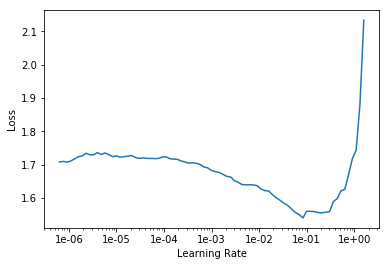

In [141]:
learn_classifier.recorder.plot()

In [145]:
learn_classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.120519,0.981789,0.592785,14:54


In [146]:
learn_classifier.save('first')

In [147]:
learn_classifier.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (124848 items)
x: TextList
xxbos a series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .,xxbos a series of escapades demonstrating the adage that what is good for the goose,xxbos a,xxbos series,xxbos of escapades demonstrating the adage that what is good for the goose
y: CategoryList
1,2,2,2,2
Path: .;

Valid: LabelList (31212 items)
x: TextList
xxbos the upper class,xxbos slightly sunbaked and summery,xxbos be something really good,xxbos me want to get made - up and go see this movie with my sisters,xxbos it unexpectedly rewarding
y: CategoryList
2,2,3,3,3
Path: .;

Test: LabelList (66292 items)
x: TextList
xxbos xxmaj an intermittently pleasing but mostly routine effort .,xxbos xxmaj an intermittently pleasing but mostly routine effort,xxbos xxmaj an,xxbos intermittently pleasing but mostly routine ef

In [150]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.022049,0.916852,0.617327,16:43
1,0.911685,0.843484,0.649077,16:14
2,0.867759,0.836016,0.657471,15:52


In [151]:
learn_classifier.save('second')

In [157]:
learn_classifier.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (124848 items)
x: TextList
xxbos a series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .,xxbos a series of escapades demonstrating the adage that what is good for the goose,xxbos a,xxbos series,xxbos of escapades demonstrating the adage that what is good for the goose
y: CategoryList
1,2,2,2,2
Path: .;

Valid: LabelList (31212 items)
x: TextList
xxbos the upper class,xxbos slightly sunbaked and summery,xxbos be something really good,xxbos me want to get made - up and go see this movie with my sisters,xxbos it unexpectedly rewarding
y: CategoryList
2,2,3,3,3
Path: .;

Test: LabelList (66292 items)
x: TextList
xxbos xxmaj an intermittently pleasing but mostly routine effort .,xxbos xxmaj an intermittently pleasing but mostly routine effort,xxbos xxmaj an,xxbos intermittently pleasing but mostly routine ef

In [152]:
learn_classifier.show_results()

text,target,prediction
"xxbos reminds us how realistically nuanced a xxmaj robert xxmaj de xxmaj niro performance can be when he is not more lucratively engaged in the shameless self - caricature of ` xxmaj analyze xxmaj this ' xxup -lrb- 1999 xxup -rrb- and ` xxmaj analyze xxmaj that , ' promised xxup -lrb- or threatened xxup -rrb- for later this year",3,2
"xxbos xxmaj it may not be as cutting , as witty or as true as back in the glory days of xxmaj weekend and xxmaj two or xxmaj three xxmaj things i xxmaj know xxmaj about xxmaj her , but who else engaged in filmmaking today is so cognizant of the cultural and moral issues involved in the process ?",2,2
"xxbos may not be as cutting , as witty or as true as back in the glory days of xxmaj weekend and xxmaj two or xxmaj three xxmaj things i xxmaj know xxmaj about xxmaj her , but who else engaged in filmmaking today is so cognizant of the cultural and moral issues involved in the process ?",3,2
"xxbos we got xxmaj ten xxmaj little xxmaj indians meets xxmaj friday the 13th by way of xxmaj clean and xxmaj sober , filmed on the set of xxmaj carpenter 's xxmaj the xxmaj thing and loaded with actors you 're most likely to find on the next inevitable incarnation of xxmaj the xxmaj love xxmaj boat .",1,1
"xxbos xxmaj the star who helped give a spark to ` ` xxmaj chasing xxmaj amy '' and ` ` xxmaj changing xxmaj lanes '' falls flat as thinking man xxup cia agent xxmaj jack xxmaj ryan in this summer 's new action film , ` ` xxmaj the xxmaj sum of xxmaj all xxmaj fears . ''",1,1


## Submit 6

In [153]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)

In [156]:
test_id = df_test['PhraseId']
submit_6 = pd.DataFrame({'PhraseId': test_id, 'Sentiment': labels})
submit_6.to_csv('submit_6.csv', index=False)
submit_6.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,3


In [159]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.867924,0.805753,0.666154,33:18
1,0.791583,0.773673,0.676663,30:49


In [160]:
learn_classifier.save('third')

In [161]:
learn_classifier.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (124848 items)
x: TextList
xxbos a series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .,xxbos a series of escapades demonstrating the adage that what is good for the goose,xxbos a,xxbos series,xxbos of escapades demonstrating the adage that what is good for the goose
y: CategoryList
1,2,2,2,2
Path: .;

Valid: LabelList (31212 items)
x: TextList
xxbos the upper class,xxbos slightly sunbaked and summery,xxbos be something really good,xxbos me want to get made - up and go see this movie with my sisters,xxbos it unexpectedly rewarding
y: CategoryList
2,2,3,3,3
Path: .;

Test: LabelList (66292 items)
x: TextList
xxbos xxmaj an intermittently pleasing but mostly routine effort .,xxbos xxmaj an intermittently pleasing but mostly routine effort,xxbos xxmaj an,xxbos intermittently pleasing but mostly routine ef

In [162]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)
test_id = df_test['PhraseId']
submit_7 = pd.DataFrame({'PhraseId': test_id, 'Sentiment': labels})
submit_7.to_csv('submit_7.csv', index=False)
submit_7.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
